In [1]:
import os
from dotenv import load_dotenv
import comet_ml
# from comet_ml import Experiment

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.feature_selection import SelectFromModel, RFE

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, brier_score_loss, f1_score, PrecisionRecallDisplay
from sklearn.calibration import CalibrationDisplay

PATH_REL_PREFIX = '..'
load_dotenv(f'{PATH_REL_PREFIX}/.env')
COMET_API_KEY = os.getenv('COMET_API_KEY')
exp = comet_ml.Experiment(
    api_key=COMET_API_KEY,
    project_name='ift6758',
    workspace='meriembchaaben',
)
exp.set_name('Question6/YourBestShot-XGB-CV-FS-RFE-XGB')

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/meriembchaaben/ift6758/6b56e4f49b6740548f83d6a16c13dc6d



In [2]:
def compute_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        rate = goals / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(rate)
    return percentiles, rates

def compute_cumulative_goal_rate_per_percentile(probs, y):
        percentiles = []
        rates = []
        cum_rate = 0

        for i in range(0, 101):
            percentile = np.percentile(probs, i)
            goals = 0
            no_goals = 0
            for idx, p in enumerate(probs):
                if p<=percentile:
                    if y[idx]==1:
                        goals+=1
                    else:
                        no_goals+=1
            cum_rate += goals / (goals + no_goals)
            percentiles.append(percentile)
            rates.append(cum_rate)
        return percentiles, rates


def plot_metrics(pipe):
    params = init_params.copy()
    random_clf = DummyClassifier(strategy="uniform").fit(X_train, y_train)
    random_probs = random_clf.predict_proba(X_val)[:, 1]
    y_val_pred = pipe.predict_proba(X_val)[:,1]
    y_val_pred_bin = pipe.predict(X_val)

    val_f1 = f1_score(y_val.to_numpy(), y_val_pred_bin, average='macro')
    val_brier = brier_score_loss(y_val.to_numpy(), y_val_pred_bin)
    
    #F1 Score (Macro)
    print(f'F1 Score (Macro) Validation: {val_f1}')
    exp.log_metric('F1 Score (Macro) Validation', val_f1)

    #Brier Score 
    print(f'Brier Score Validation: {val_brier}')
    exp.log_metric('Brier Score Validation', val_brier)

    # Confusion Matrix
    print(confusion_matrix(y_val.to_numpy(), y_val_pred_bin))
    exp.log_confusion_matrix(y_val.to_numpy(), y_val_pred_bin)

    # Classification Report
    print(classification_report(y_val.to_numpy(), y_val_pred_bin, output_dict=False))
    exp.log_text(classification_report(y_val, y_val_pred_bin, output_dict=False))

    ### PR Curve -- AUC metric ###
    display = PrecisionRecallDisplay.from_estimator(
        pipe, X_val, y_val, name=f"{init_params['classifier']}"
    )
    display.ax_.set_title("2-class Precision-Recall curve")
    exp.log_figure('PR AUC Curve', display.figure_)

    ### ROC curve - AUC metric ###
    pipe_roc_auc = roc_auc_score(y_val, y_val_pred)
    random_auc = roc_auc_score(y_val, random_probs)
    print('Our Model: ROC AUC=%.3f' % (pipe_roc_auc))
    print('Random: ROC AUC=%.3f' % (random_auc))
    exp.log_metric('ROC AUC', pipe_roc_auc)
    xgb_fpr, xgb_tpr, _ = roc_curve(y_val, y_val_pred)
    plt.figure(figsize=(6, 6))
    plt.plot(xgb_fpr, xgb_tpr, marker='.', label=f'{params["classifier"]}')
    plt.plot([0, 1], [0, 1], linestyle='--', marker='.', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    exp.log_figure('ROC AUC Curve', plt)
    # plt.savefig('../figures/roc.png')
    plt.show()


    # The goal rate (#goals / (#no_goals + #goals)) as a function of the shot probability model percentile,
    # i.e. if a value is the 70th percentile, it is above 70% of the data. 
    ### goal_rate = F(shot probability model percentile) ###
    percentiles1, rates1 = compute_goal_rate_per_percentile(y_val_pred, y_val.to_numpy())
    percentiles2, rates2 = compute_goal_rate_per_percentile(random_probs, y_val.to_numpy())
    plt.figure(figsize=(6, 6))
    plt.plot(percentiles1, rates1, marker='.', label=f'{params["classifier"]}')
    plt.plot(percentiles2, rates2, marker='.', label='Random')
    plt.xlabel('Shot probability model percentile')
    plt.ylabel('Goal rate')
    plt.legend()
    # plt.savefig('../figures/goal_rate_percentile_1.png')
    exp.log_figure('Goal Rate vs Predicted Percentile', plt)
    plt.show()


    # c. The cumulative proportion of goals (not shots) as a function of the shot probability model percentile.
    percentiles1, rates1 = compute_cumulative_goal_rate_per_percentile(y_val_pred, y_val.to_numpy())
    percentiles2, rates2 = compute_cumulative_goal_rate_per_percentile(random_probs, y_val.to_numpy())
    plt.figure(figsize=(6, 6))
    plt.plot(percentiles1, rates1, marker='.', label=f'{params["classifier"]}')
    plt.plot(percentiles2, rates2, marker='.', label='Random')
    plt.xlabel('Shot probability model percentile')
    plt.ylabel('Goal rate')
    plt.legend()
    # plt.savefig('../figures/goal_rate_percentile_2.png')
    exp.log_figure('Cumulative Goal Rate vs Predicted Percentile', plt)
    plt.show()

    # d. The reliability diagram (calibration curve).
    fig, ax = plt.subplots(figsize=(6, 6))
    disp1 = CalibrationDisplay.from_estimator(pipe, X_val, y_val, label=f'{params["classifier"]}', ax=ax)
    disp4 = CalibrationDisplay.from_estimator(random_clf, X_val, y_val, label='Random', ax=ax)
    # plt.savefig('../figures/calibration_diagram.png')
    exp.log_figure('Reliability Diagram', plt)
    plt.show()



def create_pipeline(params):
    encoder = params.get('encoder', 'OrdinalEncoder')
    feature_selection=params.get('feature_selection', None)
    n_features_to_select=params.get('n_features_to_select', 3)
    classifier=params.get('classifier', 'GaussianNB')

    # MLPClassifier
    hidden_layer_sizes=params.get('hidden_layer_sizes', (100,))
    early_stopping = params.get('early_stopping', True)

    # XGBoostClassifier
    max_depth = params.get('max_depth', 6)
    n_estimators = params.get('n_estimators', 100)
    reg_alpha=params.get('reg_alpha', 0)
    reg_lambda=params.get('reg_lambda', 1)
    min_child_weight = params.get('min_child_weight', 1)
    gamma = params.get('gamma', 0)
    subsample = params.get('subsample', 1)
    colsample_bytree = params.get('colsample_bytree', 1)
    use_label_encoder=params.get('use_label_encoder', False)
    tree_method=params.get('tree_method', 'hist')
    gpu_id=params.get('gpu_id', None)


    encoder_map = {
        'OrdinalEncoder': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        'OneHotEncoder': OneHotEncoder(handle_unknown='ignore')
    }

    feature_selection_map = {
        'SelectFromModel_LinearSVC': SelectFromModel(LinearSVC(C=0.1, penalty="l1", dual=False)),
        'RFE_GaussianNB': RFE(GaussianNB(), n_features_to_select=n_features_to_select, step=1),
        'RFE_RandomForestClassifier': RFE(RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators), n_features_to_select=n_features_to_select, step=1),
        'RFE_XGBClassifier': RFE(
            XGBClassifier(
                max_depth=max_depth,
                n_estimators=n_estimators,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                min_child_weight=min_child_weight,
                gamma=gamma,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                use_label_encoder=use_label_encoder,
                objective='binary:logistic',
                eval_metric=brier_score_loss,
                tree_method=tree_method,
                gpu_id=gpu_id,
            ),
            n_features_to_select=n_features_to_select, step=1
        ),
    }

    classifier_map = {
        'GaussianNB': GaussianNB(),
        'RandomForestClassifier': RandomForestClassifier(
            max_depth=max_depth,
            n_estimators=n_estimators
        ),
        'XGBClassifier': XGBClassifier(
            max_depth=max_depth,
            n_estimators=n_estimators,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            min_child_weight=min_child_weight,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            use_label_encoder=use_label_encoder,
            objective='binary:logistic',
            eval_metric='logloss',
            tree_method=tree_method,
            gpu_id=gpu_id,
        ),
        'MLPClassifier': MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            early_stopping=early_stopping,
        ),
    }

    numeric_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing Data')),
        ('encoder', encoder_map[encoder]),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, make_column_selector(dtype_include="number")),
            ("cat", categorical_transformer, make_column_selector(dtype_exclude="number")),
        ]
    )

    if feature_selection:
        feature_selection = [('feature_selection', feature_selection_map[feature_selection])]
    else:
        feature_selection = []

    pipe = Pipeline(steps=[('preprocessor', preprocessor)] + feature_selection + [('classifier', classifier_map[classifier])])
    
    return pipe


In [3]:
# Load Data
df = pd.read_csv(f'{PATH_REL_PREFIX}/data/M2Data/trainingSet.csv')
df['strength'] = df['strength2']

df['rebound'] = df.rebound.astype(int)
df['Goal'] = df['Goal'].astype(int)
df['EmptyNet'] = df['EmptyNet'].astype(int)

df = df.drop(labels=[
    'totalPlayTime', 'gameID', 'eventType',
    'lastEventPeriodTime',
    'strength2',
    'lastEventAngle',
    'lastEventGameSeconds',
    'emptyNet',
    'lastEventPeriod',
    'xCoord', 'yCoord',
    'lastEventXCoord', 'lastEventYCoord',
    'index',
], axis=1, errors='ignore')


# Train / Valid Split
season_split = 2018
X, y = df.drop(labels='Goal', axis=1), df['Goal']
train_ix, valid_ix = df[df.season < season_split].index, df[df.season >= season_split].index
X_train, X_val, y_train, y_val = X.iloc[train_ix], X.iloc[valid_ix], y.iloc[train_ix], y.iloc[valid_ix]

exp.log_dataset_info(name='trainingSet.csv', version='2021-11-17', path=f'{PATH_REL_PREFIX}/data/M2Data/trainingSet.csv')

for dataset in [X_train, X_val, y_train, y_val]:
    exp.log_dataset_hash(dataset)

X_train.shape, X_train.columns, y_train.shape, y_train.name

((230628, 25),
 Index(['period', 'periodTime', 'periodType', 'teamOfShooter', 'homeOrAway',
        'shooter', 'goalie', 'shotType', 'strength', 'season', 'rinkSide',
        'gameType', 'lastEventType', 'EmptyNet', 'distanceFromNet', 'angle',
        'gameSeconds', 'timeFromLastEvent', 'distanceFromLastEvent', 'rebound',
        'changeInAngleShot', 'speed', 'timeSincePowerPlayStarted',
        'numFriendlyNonGoalieSkaters', 'numOpposingNonGoalieSkaters'],
       dtype='object'),
 (230628,),
 'Goal')

In [4]:
init_params = {
    'encoder': 'OrdinalEncoder',
    'feature_selection': 'RFE_XGBClassifier',
    'n_features_to_select': 30,
    'classifier': 'XGBClassifier',
}
pipe = create_pipeline(init_params)

param_grid = {
    'feature_selection__n_features_to_select': [3,5,10,15,20,30,40,50],
    'classifier__max_depth': [1,2,3,4,5,6,7],
    'classifier__n_estimators': [10,20,40,80,120,160,200,240,280,320],
    'classifier__reg_alpha':[0, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 1,  10, 100],
    'classifier__reg_lambda':[0, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 1,  10, 100],
    'classifier__min_child_weight':[6,8,10,12],
    'classifier__gamma':[i/10.0 for i in range(0,5)],
    'classifier__subsample':[i/100.0 for i in range(75,90,5)],
    'classifier__colsample_bytree':[i/100.0 for i in range(75,90,5)],
    'classifier__use_label_encoder': [False],
    'classifier__tree_method': ['gpu_hist'],
    'classifier__gpu_id': [1],
    'classifier__scale_pos_weight': [1, 2, 3, 4, 5, 9, 45, 70, 90],
}

# Search
tscv = TimeSeriesSplit()
search = RandomizedSearchCV(
    pipe, param_grid, cv=tscv, scoring='f1_macro', random_state=0, verbose=1,
    n_iter=20,
).fit(X, y)
print('BEST PARAMS:', search.best_params_)

COMET WARNING: truncated string; too long: 'RFE(estimator=XGBClassifier(base_score=None, booster=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=1, enable_categorical=False,
                            eval_metric=<function brier_score_loss at 0x7fc2da888f70>,
                            gamma=0, gpu_id=None, importance_type=None,
                            interaction_constraints=None, learning_rate=None,
                            max_delta_step=None, max_depth=6,
                            min_child_weight=1, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=None, num_parallel_tree=None, predictor=None,
                            random_state=None, reg_alpha=0, reg_lambda=1,
                            scale_pos_weight=None, subsample=1,
                            tree_method='hist', use_label_encoder=False,
                       

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/smuchi/miniconda3/envs/iftxgb/lib/python3.10/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET WARNING: You must install graphviz to plot tree
/home/smuchi/miniconda3/envs/iftxgb/lib/python3.10/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/smuchi/miniconda3/envs/iftxgb/lib/python3.10/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
/home/smuchi/miniconda3/envs/iftxgb/lib/python3.10/site-packages/xgboost/training.py:17: Us

BEST PARAMS: {'feature_selection__n_features_to_select': 30, 'classifier__use_label_encoder': False, 'classifier__tree_method': 'gpu_hist', 'classifier__subsample': 0.85, 'classifier__scale_pos_weight': 5, 'classifier__reg_lambda': 0, 'classifier__reg_alpha': 100, 'classifier__n_estimators': 200, 'classifier__min_child_weight': 6, 'classifier__max_depth': 6, 'classifier__gpu_id': 1, 'classifier__gamma': 0.3, 'classifier__colsample_bytree': 0.85}


In [5]:
pipe = search.best_estimator_
pipe

In [6]:
# Score
pipe = search.best_estimator_
f1_weighted_scores = cross_val_score(pipe, X, y, scoring='f1_weighted', cv=tscv, n_jobs=-1)
roc_auc_scores = cross_val_score(pipe, X, y, scoring='roc_auc', cv=tscv, n_jobs=-1)
print('Weighted F1 SCORES', f1_weighted_scores)
print('Mean Weighted F1 Scores: %.5f' % np.mean(f1_weighted_scores))
print('ROC AUC SCORES', roc_auc_scores)
print('Mean ROC AUC: %.5f' % np.mean(roc_auc_scores))
exp.log_parameter('init_params', init_params)
exp.log_parameter('best_params', search.best_params_)
# exp.log_metric('AUC ROC CV Scores Valid', scores)
exp.log_metric('Weighted F1 CV Mean Score Valid', np.mean(f1_weighted_scores))
exp.log_metric('AUC ROC CV Mean Score Valid', np.mean(roc_auc_scores))


[14:10:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:10:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:10:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:10:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [7]:
pipe.fit(X_train, y_train)


COMET WARNING: truncated string; too long: 'RFE(estimator=XGBClassifier(base_score=None, booster=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=1, enable_categorical=False,
                            eval_metric=<function brier_score_loss at 0x7fc2da888f70>,
                            gamma=0, gpu_id=None, importance_type=None,
                            interaction_constraints=None, learning_rate=None,
                            max_delta_step=None, max_depth=6,
                            min_child_weight=1, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=None, num_parallel_tree=None, predictor=None,
                            random_state=None, reg_alpha=0, reg_lambda=1,
                            scale_pos_weight=None, subsample=1,
                            tree_method='hist', use_label_encoder=False,
                       

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fc2b4389240>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing '
                                                                                            'Data',
                                                                                 strategy='

F1 Score (Macro) Validation: 0.6141792565185694
Brier Score Validation: 0.1749546459902085
[[62947  9766]
 [ 4314  3451]]
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     72713
           1       0.26      0.44      0.33      7765

    accuracy                           0.83     80478
   macro avg       0.60      0.66      0.61     80478
weighted avg       0.87      0.83      0.84     80478

Our Model: ROC AUC=0.773
Random: ROC AUC=0.500


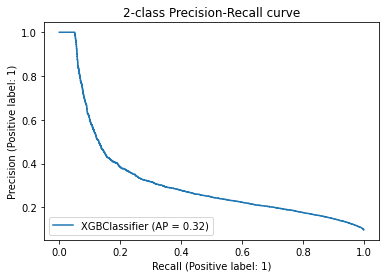

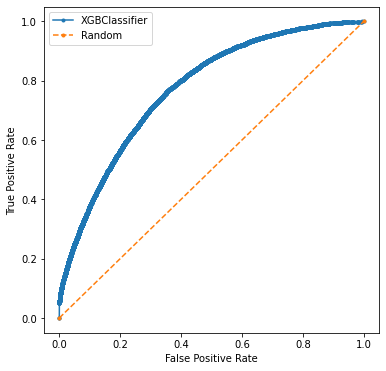

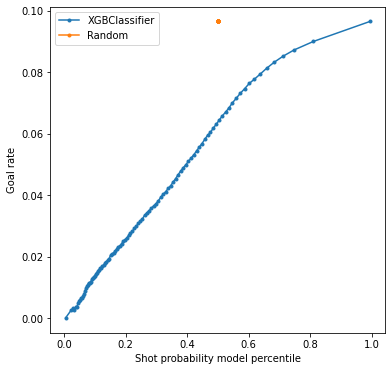

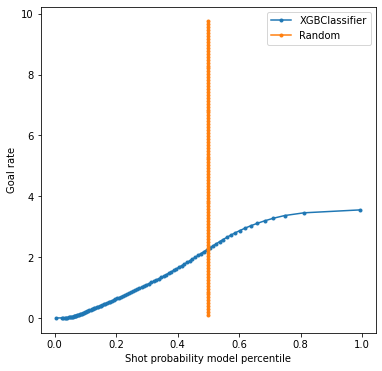

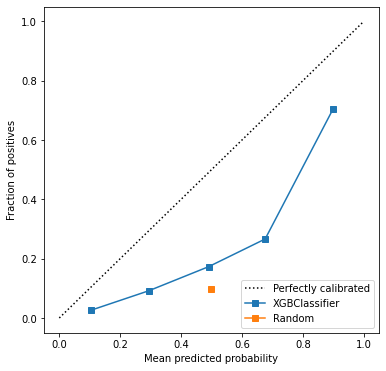

In [8]:
plot_metrics(pipe)

In [9]:
# display = PrecisionRecallDisplay.from_estimator(
#     pipe, X_val, y_val, name=f"{init_params['classifier']}"
# )
# display.ax_.set_title("2-class Precision-Recall curve")

In [10]:
# brier_score_loss(y_train, y_pred_train), brier_score_loss(y_val, y_pred_val)

In [11]:
exp.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/meriembchaaben/ift6758/6b56e4f49b6740548f83d6a16c13dc6d
COMET INFO:   Metrics:
COMET INFO:     AUC ROC CV Mean Score Valid     : 0.7738210612319198
COMET INFO:     Brier Score Validation          : 0.1749546459902085
COMET INFO:     F1 Score (Macro) Validation     : 0.6141792565185694
COMET INFO:     ROC AUC                         : 0.7734932463754223
COMET INFO:     Weighted F1 CV Mean Score Valid : 0.849272777207695
COMET INFO:   Others:
COMET INFO:     Name         : Question6/YourBestShot-XGB-CV-FS-RFE-XGB
COMET INFO:     dataset_info : trainingSet.csv-2021-11-17, ../data/M2Data/trainingSet.csv
COMET INFO:   Parameters:
COMET INFO:     add_indicator                                                    : False
COMET INFO:     begin_iteration    